# Reinforcement Learning Projekt
In der CartPole-Szenario in der OpenAI Gym-Umgebung ist das Ziel, einen Reinforcement Learning-Agenten zu entwickeln und zu optimieren, Szenario erfolgreich bewältigen kann. Der Agent sollte in der Lage sein, den Stab auf einem Wagen auszubalancieren und dabei eine möglichst hohe Belohnung zu erzielen. 

Die Anforderungen an das Projekt war nicht das Entwicklen eines perfekten Agenten, nach mein Verständnis viel mehr das Erlernen von Grundwissen in Reinforcement Learning. Das Ergebnis sollte durch eine Optimierung verbessert werden. Deshalb strebe ich mit diesem Projekt nach eine durchschnittliche Belohnung von mindestens 50 über mehrere Episoden hinweg. Oder mindestens eine Verbesserung des Agenten nach einer Optimierung. 

#### State-of-the-art
Es ist zu erwähnen, dass ich mit diesem Projekt versucht habe, selbstständig Code zu implementieren (natürlich mithilfe von bereits existierende Modelle wie __Q-Net__ oder __Dueling-Q-Net__).  Generell ist zu sagen, dass die CartPole-Umgebung bereits gut erforscht wurde, und verschiedene Reinforcement Learning-Techniken in dieser Umgebung gute Ergebnisse erzielt haben, wie das Beispiel, das ich in der __State_of_the_art.ipynb__ dargestellt habe. Dabei habe ich versucht die Grundgedanken zu verstehen.

In [1]:
import gym
import numpy as np
import random
from collections import deque
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Erstellen des RL-Agent

In [3]:
# Definition des Q-Learning-Agenten
class QLearningAgent:
    def __init__(self, state_space_size, action_space_size):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.epsilon = 1.0  # Anfangswert für die Erkundungswahrscheinlichkeit
        self.epsilon_decay = 0.995  # Faktor zur Verringerung der Erkundungswahrscheinlichkeit
        self.epsilon_min = 0.01  # Minimale Erkundungswahrscheinlichkeit
        self.learning_rate = 0.001  # Lernrate für das neuronale Netz
        self.discount_factor = 0.99  # Rabattfaktor für zukünftige Belohnungen
        self.model = self._build_model()  # Erstellung des neuronalen Netzwerks

    def _build_model(self):
        # Definition des neuronalen Netzwerks als Q-Funktion Approximator
        model = keras.Sequential([
            layers.Dense(24, input_shape=(self.state_space_size,), activation='relu'),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.action_space_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def choose_action(self, state, return_explore_action=False):
        # Wählt eine Aktion basierend auf der Erkundungswahrscheinlichkeit oder Q-Werte
        if np.random.rand() < self.epsilon:
            if return_explore_action:
                return random.randrange(self.action_space_size), True
            else:
                return random.randrange(self.action_space_size)
        q_values = self.model.predict(state)
        action = np.argmax(q_values[0])
        if return_explore_action:
            return action, False
        else:
            return action

    def train(self, state, action, reward, next_state, done):
        # Training des Agenten basierend auf Q-Learning
        target = reward
        if not done:
            target = reward + self.discount_factor * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
# definieren von Evaluationsfunktion
def evaluate_agent(env, agent, episodes=500):
    # Bewertet den Agenten über eine bestimmte Anzahl von Testepisoden (hier auf 500 geändert)
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    return np.mean(total_rewards)

### Training des RL-Agenten

In [4]:
# Initialisierung der CartPole-Umgebung und des RL-Agenten
env = gym.make('CartPole-v1')
agent = QLearningAgent(state_space_size=env.observation_space.shape[0], action_space_size=env.action_space.n)

Im folgenden Teil des Codes wird der Q-Learning-Agent trainert und seine Leistung in regelmäßigen Intervallen überwacht:



In [ ]:
# Trainieren des Agenten mit Evaluation in bestimmten Intervallen
train_episodes = 500
evaluation_interval = 25

# Listen zum Speichern der Belohnungen pro Episode und des Explorations-Exploitations-Verhältnisses
episode_rewards = []
exploration_exploitation_ratio = []

for episode in range(train_episodes):
    state = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    total_reward = 0
    total_explore_actions = 0
    total_exploit_actions = 0
    done = False

    while not done:
        action, explore_action = agent.choose_action(state, return_explore_action=True)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        agent.train(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if explore_action:
            total_explore_actions += 1
        else:
            total_exploit_actions += 1

    episode_rewards.append(total_reward)

    if (episode + 1) % evaluation_interval == 0:
        average_reward = evaluate_agent(env, agent, episodes=evaluation_interval)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Average Reward: {average_reward}")

    # Berechnung des Explorations-Exploitations-Verhältnisses für die Episode
    explore_exploit_ratio = total_explore_actions / (total_explore_actions + total_exploit_actions)
    exploration_exploitation_ratio.append(explore_exploit_ratio)


Hier ist ein Screenshot von Output, sonst würde der Output viel zu lange sein

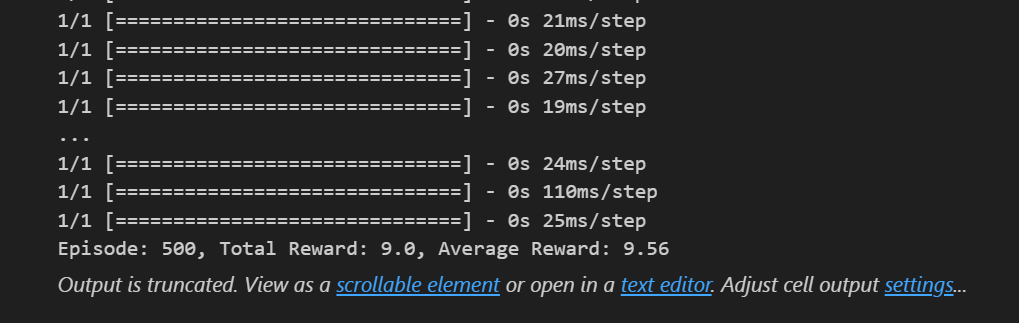

#### Interpretation
- "Episode: 500": Dies deutet darauf hin, dass der Agenten in 500 Episoden trainiert wurde.

- "Total Reward: 9.0": In einer einzelnen Episode hat der Agent eine Gesamtbelohnung von 9.0 erhalten. Die Gesamtbelohnung ist die summierte Belohnung über alle Zeitschritte in einer Episode.

- "Average Reward: 9.56": Dies ist der durchschnittliche Wert der Gesamtbelohnung über die 500 Episoden. Es bedeutet, dass der Agent im Durchschnitt 9.56 Belohnungspunkte pro Episode erhalten hat.


In deinem Fall zeigt eine durchschnittliche Belohnung von 9.56, dass der Agent ein gewisses Maß (minimal) an Lernen erreicht hat und eine positive Leistung erzielt. Allerdings ist eine durchschnittliche Belohnung von 9.56 in der CartPole-Umgebung noch nicht ausreichend, um die Umgebung als gelöst zu betrachten.

Um die Leistung des Agenten weiter zu verbessern und die CartPole-Umgebung als "gelöst" zu betrachten, strebe ich eine durchschnittliche Belohnung von mindestens 50 über mehrere Episoden hinweg an. Es sollte irgendwie gezeigt werden, dass der Agent den Stab für eine ausreichende Anzahl von Schritten ausbalancieren kann, um die Umgebung erfolgreich zu meistern. Im Weiteren Verlauf nach der Initial Visualisierung, werde ich versuchen, das Ergebnis zu optimieren, oder zu mindestens versuchen zu erhöhen


 #

###

## Visualisierung

#### Interpretation von Belohnungsentwicklung während des Trainings

Wenn die Belohnungsentwicklung zu Beginn bei ca.12 liegt und dann ab der 25. Episode variabel mehr oder weniger mit vereinzelten Ausnahmen zwischen 9 und 10 bleibt, kann dies bedeuten, dass der Agent zuerst eine schnellere Lernphase durchläuft, in der er das Spielverhalten verbessert und die Belohnungen steigen. Nach dieser anfänglichen Verbesserung erreicht der Agent möglicherweise ein Plateau, auf dem er eine gewisse Konsistenz in den Belohnungen zeigt. Ein stabiler Wert um 9 bis 10 deutet darauf hin, dass der Agent Schwierigkeiten hat, die Belohnung weiter zu erhöhen.

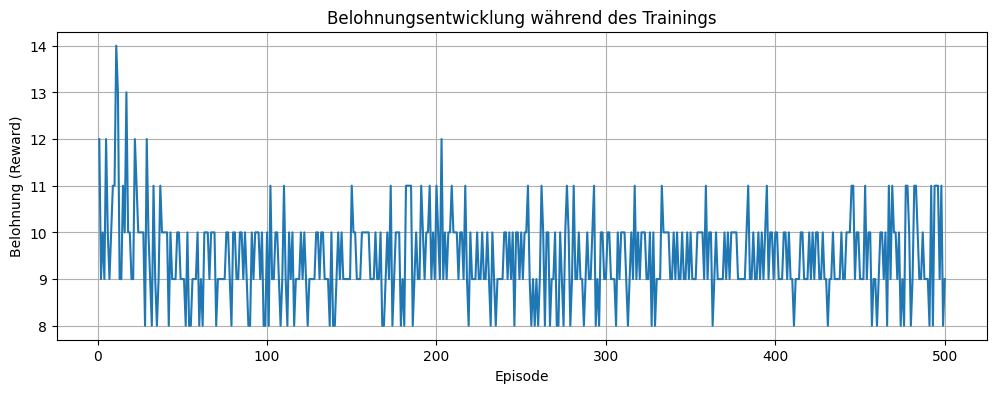

In [22]:
# Plot der Belohnungsentwicklung
plt.figure(figsize=(12, 4))
plt.plot(range(1, train_episodes + 1), episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Belohnung (Reward)')
plt.title('Belohnungsentwicklung während des Trainings')
plt.grid(True)
plt.show()

#### Interpretation des Exploration-Exploitations-Verhältnisses

Wenn das Explorations-Exploitations-Verhältnis zu Beginn einen Wert von 0,35 hat und dann im Verlauf der Episoden öfters einen lokalen Maxima von 0,1 erreicht, deutet dies darauf hin, dass der Agent möglicherweise zu Beginn mehr Exploration (zufällige Aktionen) durchgeführt hat, um die Umgebung zu erkunden und möglicherweise bessere Aktionen zu finden. Im Laufe des Trainings hat der Agent jedoch mehr verhängt hat (siehe Belohungsentwicklung)

#### 

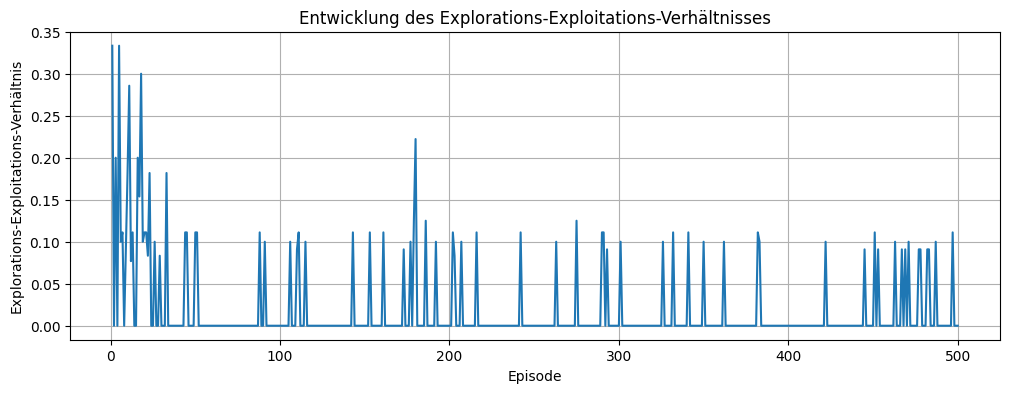

In [23]:
# Plot des Explorations-Exploitations-Verhältnisses
plt.figure(figsize=(12, 4))
plt.plot(range(1, train_episodes + 1), exploration_exploitation_ratio)
plt.xlabel('Episode')
plt.ylabel('Explorations-Exploitations-Verhältnis')
plt.title('Entwicklung des Explorations-Exploitations-Verhältnisses')
plt.grid(True)
plt.show()

#### Interpretation der Initial Visualisierung

Die beiden Plots, reichen für die Darstellung des Trainingsverlaufs und der Ergebnisse als geeigneten und verständlichen Visualisierungen aus. Die Plots geben eine klare Vorstellung von der Entwicklung der Belohnung während des Trainings sowie des Explorations-Exploitations-Verhältnisses.

Mit dem Plot der Belohnungsentwicklung kann man den Trainingsfortschritt des RL-Agenten verfolgen und sehen, wie sich die Belohnung im Verlauf der Episoden ändert. In diesem speziellen Fall ist die Entwicklung nicht als potitiv zu bewerten, da es mit der Zeit keine Steigung mehr zu sehen ist. Der zweite Plot des Explorations-Exploitations-Verhältnisses zeigt, wie oft der Agent zufällige Aktionen im Vergleich zu gelernten Aktionen auswählt. Dies kann helfen, die Explorations-Exploitations-Strategie des Agents zu bewerten.

Ich halte nochmal fest, ich strebe nach eine durchschnittliche Belohnung von mindestens 50 über mehrere Episoden hinweg.


#

## Optimierung durch Q-Network Erweiterung
Der Code, den ich zuvor implementiert habe, ist ein einfaches Q-Learning-Agenten mit einem einfachen neuralen Netzwerk als Q-Funktion Approximator. In diesem einfachen Q-Learning-Netzwerk wird die Q-Funktion direkt aus dem Zustand berechnet und verwendet, um die beste Aktion zu wählen und das Netzwerk zu trainieren.

Mit dem Dueling Q-Network-Ansatz erweitert man nun das einfache Q-Learning-Netzwerk, indem man eine andere Netzwerkarchitektur verwendet. Anstatt die Q-Werte direkt aus dem Zustand zu berechnen, wird die Q-Funktion in zwei separate Teile aufgeteilt: den V-Wert (Value) und den A-Wert (Advantage). Der V-Wert gibt den erwarteten Wert des Zustands an, unabhängig von der ausgewählten Aktion, und der A-Wert gibt den zusätzlichen Wert oder Vorteil jeder Aktion gegenüber dem V-Wert an. Durch diese Aufteilung wird der Dueling Q-Network-Ansatz die Wertfunktion effizienter lernen und stabiler gegenüber Schwankungen in der Umgebung sein. Es wird angenommen, dass die V-Werte in vielen Zuständen stabil sind und sich langsam ändern, während die A-Werte oft stärkere Änderungen aufweisen. Dies erlaubt es dem Agenten, sich auf Bereiche zu konzentrieren, in denen eine Aktion besonders vorteilhaft ist, anstatt den Wert jeder Aktion in jedem Zustand separat zu erlernen.

Vorteile und Gründe für meine Entscheidung:
- Effizientes Lernen: Durch die Aufteilung der Q-Funktion in V-Wert und A-Wert kann das Dueling Q-Network effizienter lernen, indem es den erwarteten Wert des Zustands unabhängig von den spezifischen Aktionen und den Vorteil jeder Aktion gegenüber dem erwarteten Wert lernt. Dies ermöglicht eine bessere Nutzung der begrenzten Trainingsdaten und kann dazu beitragen, das Problem der Wertfunktionsschätzung in großen Zustandsräumen zu bewältigen.
- Stabilität des Lernens: Das Dueling Q-Network kann zur Stabilität des Lernens beitragen, indem es eine bessere Approximation der Q-Funktion ermöglicht. Die Stabilität ist wichtig, um ein zu starkes Schwanken der Q-Werte zu vermeiden und ein reibungsloses und konvergentes Lernen des Agenten zu gewährleisten.
- Bessere Generalisierung: Die Trennung von V-Wert und A-Wert ermöglicht es dem Dueling Q-Network, Unterschiede in den Wertfunktionen für verschiedene Aktionen in ähnlichen Zuständen besser zu erfassen. Dies führt zu einer verbesserten Generalisierungsfähigkeit, wodurch der Agent besser auf unbekannten Zuständen und Situationen reagieren kann.
- Minderung des Overestimation-Bias: Q-Learning kann dazu neigen, die Q-Werte zu überschätzen (Overestimation-Bias), was zu schlechteren Entscheidungen und Leistung führen kann. Das Dueling Q-Network kann dieses Problem durch die Trennung von V-Wert und A-Wert verringern und so die Präzision der Q-Werte verbessern.
- Einfache Implementierung: Obwohl das Dueling Q-Network eine andere Architektur als das einfache Q-Learning-Netzwerk hat, ist die Implementierung relativ einfach und erfordert nur geringfügige Modifikationen am ursprünglichen Netzwerk.



In [5]:
# Definition des Dueling Q-Learning-Agenten
class DuelingQLearningAgent:
    def __init__(self, state_space_size, action_space_size):
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.model = self._build_model()
        self.exploration_count = 0
        self.exploitation_count = 0

    def _build_model(self):
        # Dueling Q-Network: Aufteilen in V-Wert und A-Wert
        inputs = layers.Input(shape=(self.state_space_size,))
        dense1 = layers.Dense(24, activation='relu')(inputs)
        dense2 = layers.Dense(24, activation='relu')(dense1)

        # V-Wert-Schätzer
        value_stream = layers.Dense(1, activation='linear')(dense2)
        value_stream = layers.Lambda(lambda s: keras.backend.expand_dims(s[:, 0], -1), output_shape=(self.action_space_size,))(value_stream)

        # A-Wert-Schätzer
        advantage_stream = layers.Dense(self.action_space_size, activation='linear')(dense2)
        advantage_stream = layers.Lambda(lambda a: a - keras.backend.mean(a, axis=1, keepdims=True), output_shape=(self.action_space_size,))(advantage_stream)

        # Zusammenführen von V-Wert und A-Wert, um Q-Werte zu erhalten
        q_values = layers.Add()([value_stream, advantage_stream])

        model = keras.Model(inputs=inputs, outputs=q_values)
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            self.exploration_count += 1
            return random.randrange(self.action_space_size)
        else:
            self.exploitation_count += 1
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def train(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.discount_factor * np.amax(self.model.predict(next_state)[0])
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def evaluate_agent_DQ(env, agent, episodes=500):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    return np.mean(total_rewards)



In [6]:
# Initialisierung der CartPole-Umgebung und des Dueling Q-Learning-Agenten
env_DQ = gym.make('CartPole-v1')
agent_DQ = DuelingQLearningAgent(state_space_size=env_DQ.observation_space.shape[0], action_space_size=env_DQ.action_space.n)

train_episodes_DQ = 300
evaluation_episodes_DQ = 100
evaluation_interval_DQ = 25

In [8]:
reward_history_DQ = []
exploration_exploitation_ratio_DQ = []  # Liste zum Speichern des Exploration-Exploitation-Verhältnisses

for episode in range(train_episodes_DQ):
    state = env_DQ.reset()
    state = np.reshape(state, [1, env_DQ.observation_space.shape[0]])
    total_reward = 0
    done = False

    while not done:
        action = agent_DQ.choose_action(state)
        next_state, reward, done, _ = env_DQ.step(action)
        next_state = np.reshape(next_state, [1, env_DQ.observation_space.shape[0]])
        agent_DQ.train(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    reward_history_DQ.append(total_reward)
    exploration_exploitation_ratio_DQ.append(agent_DQ.exploration_count / agent_DQ.exploitation_count)

    if (episode + 1) % evaluation_interval == 0:
        average_reward = evaluate_agent_DQ(env_DQ, agent_DQ, episodes=evaluation_episodes_DQ)
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Average Reward: {average_reward}")

1/1 [==============================] - 0s 35ms/step
Episode: 25, Total Reward: 10.0, Average Reward: 10.37
1/1 [==============================] - 0s 27ms/step
Episode: 50, Total Reward: 9.0, Average Reward: 9.78
1/1 [==============================] - 0s 28ms/step
Episode: 75, Total Reward: 10.0, Average Reward: 9.52
1/1 [==============================] - 0s 66ms/step
Episode: 100, Total Reward: 10.0, Average Reward: 9.41
1/1 [==============================] - 0s 24ms/step
Episode: 125, Total Reward: 10.0, Average Reward: 9.4
1/1 [==============================] - 0s 31ms/step
Episode: 150, Total Reward: 10.0, Average Reward: 9.25
1/1 [==============================] - 0s 34ms/step
Episode: 175, Total Reward: 9.0, Average Reward: 9.38
1/1 [==============================] - 0s 59ms/step
Episode: 200, Total Reward: 9.0, Average Reward: 9.37
1/1 [==============================] - 0s 28ms/step
Episode: 225, Total Reward: 9.0, Average Reward: 9.73
1/1 [==============================] - 0s 28

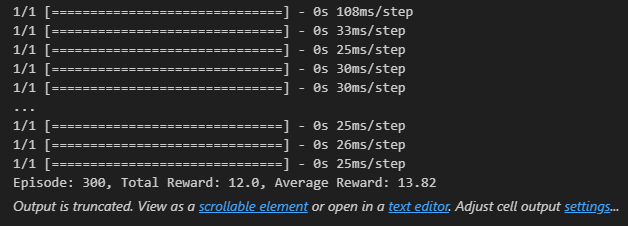

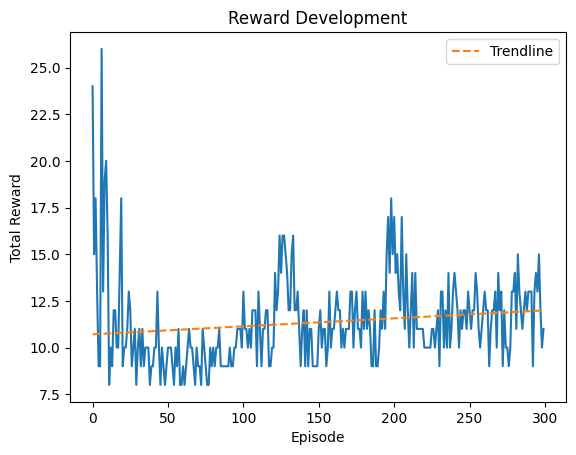

In [12]:
# Plot 1 (Interpretation siehe Ergebnis Teil)

# Plot der Belohnungsentwicklung während des Trainings
plt.plot(reward_history_DQ)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Development')

# Hinzufügen der Trendlinie
x = np.arange(len(reward_history_DQ))
coefficients = np.polyfit(x, reward_history_DQ, 1)
trendline = np.polyval(coefficients, x)
plt.plot(x, trendline, linestyle='dashed', label='Trendline')

plt.legend()
plt.show()

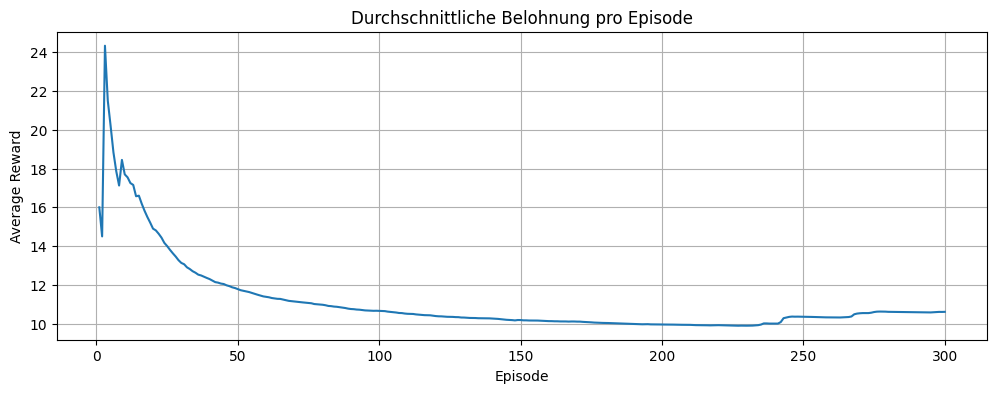

In [19]:
# Plot 2 (Interpretation siehe Ergebnis Teil)

# Durchschnittliche Belohnung pro Episode
average_rewards = [np.mean(reward_history_DQ[:i]) for i in range(1, train_episodes_DQ + 1)]
plt.figure(figsize=(12, 4))
plt.plot(range(1, train_episodes_DQ + 1), average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Durchschnittliche Belohnung pro Episode')
plt.grid(True)
plt.show()

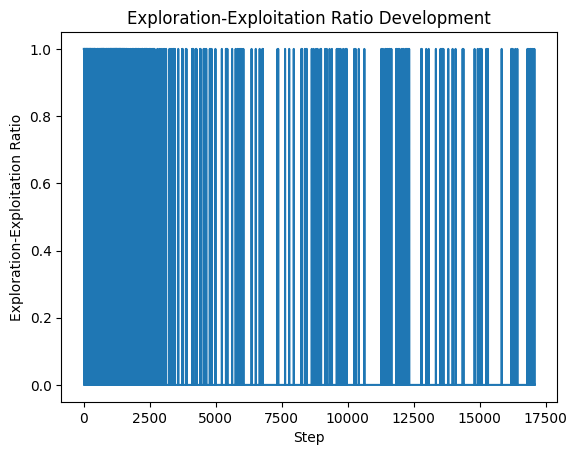

In [14]:
# Plot 3 (Interpretation siehe Ergebnis Teil)

# Plot des Exploration-Exploitation-Verhältnisses
explore_exploit_ratio = agent_DQ.explore_exploit_ratio
plt.plot(range(len(explore_exploit_ratio)), explore_exploit_ratio)
plt.xlabel('Step')
plt.ylabel('Exploration-Exploitation Ratio')
plt.title('Exploration-Exploitation Ratio Development')
plt.show()

In [27]:
# Maximale Belohnung pro Episode
max_reward = np.max(reward_history_DQ)
print(f"Maximale Belohnung pro Episode: {max_reward}")
# Anzahl der Episoden, in denen der Agent das Ziel erreicht hat
goal_reached_episodes = sum(1 for reward in reward_history_DQ if reward >= env_DQ.spec.reward_threshold)
print(f"Anzahl der Episoden, in denen das Ziel erreicht wurde: {goal_reached_episodes}")


Maximale Belohnung pro Episode: 59.0
Anzahl der Episoden, in denen das Ziel erreicht wurde: 0


----------------------------------------------------------

## Ergebins Interpretation und Fazit

Das Ergebnis deutet darauf hin, dass der implementierte Dueling Q-Learning-Agent nicht optimal trainiert ist und Verbesserungspotenzial hat. 
- Total Reward von __12__ und Average Reward von __13.82__ für 300 Episoden: Ein Total Reward von 12 für die CartPole-Umgebung ist sehr niedrig und deutet darauf hin, dass der Agent in den meisten Episoden nicht gut abschneidet. Der Average Reward von 13.82 ist etwas höher, was darauf hindeutet, dass der Agent gelegentlich auch gute Episoden mit höheren Belohnungen erreicht. Allerdings ist die Performance insgesamt noch nicht zufriedenstellend.
- Trendlinie in __Plot 1__ der Belohnungsentwicklung: Die geringe Steigung der Trendlinie in der Belohnungsentwicklung deutet darauf hin, dass der Agent Schwierigkeiten hat, seine Leistung im Laufe der Episoden zu verbessern. Dies könnte darauf hindeuten, dass der Agent nicht in der Lage ist, aus seinen Erfahrungen zu lernen und die besten Aktionen für verschiedene Zustände zu identifizieren.
- __Plot 2__, "Durchschnittlichen Belohnung pro Episode" zeigt, wie sich die durchschnittliche Belohnung, die der Agent in jeder Episode erhält, im Laufe des Trainings entwickelt. Der Anstieg zu Beginn deutet darauf hin, dass der Agent anfänglich Fortschritte macht und gute Belohnungen erhält. Der spätere Abfall deutet auf Schwierigkeiten und Herausforderungen hin. Der erneute Anstieg nach etwa 250 Episoden zeigt eine mögliche Verbesserung der Leistung, wenn es mehr Episoden gegeben hätten (aufgrund von hardware Verfügbarkeit leider nicht möglich).
- __PLot 3__ Exploration-Exploitation Ratio Development: Die beobachtete "Barcode"-ähnliche Struktur im Exploration-Exploitation-Verhältnis kann darauf hindeuten, dass der Agent während des Trainings zwischen Erkundung und Ausbeutung hin- und herwechselt. Dies kann ein Indiz dafür sein, dass der Agent möglicherweise Schwierigkeiten hat, das richtige Gleichgewicht zwischen Exploration (Erforschung neuer Aktionen) und Exploitation (Ausnutzung der bisher gelernten Aktionen) zu finden.


Ich halte zudem fest, das das Projekt eine durchschnittliche Belohnung von mindestens 50 über mehrere Episoden hinweg __nicht erreicht__ hat, wie ich es mir als "Ziel" gesetzt habe. Einen Wert über 50 wurde nur vereinzelnt erreicht. Desweiteren hat der implementierter Agent leider kein einziges Mal die von Openai definierte reward_threshold erreicht.  


Aber dennoch ist es anzumerken, dass der __Dueling Q-Learning-Ansatz den ursprünglichen Ansatz des einfachen Q-Learning-Netzes verbessert__. Der ursprüngliche Q-Learning-Agent hatte einen Total Reward von 9 und einen durchschnittlichen Reward von 9.56, während der Dueling Q-Learning-Agent einen Total Reward von 12 und einen durchschnittlichen Reward von 13.82 erreichte. Dies zeigt, dass der Dueling Q-Learning-Ansatz (als Optimierung) eine bessere Leistung erzielt hat als der ursprüngliche Q-Learning-Ansatz in diesem speziellen Szenario (CartPole-Umgebung). Die Verbesserung ist zwar moderat, aber dennoch positiv. Somit habe ich mein selstgesetztes Ziel in gewisser maßen erreicht.


-----------------------------------------------------------------------------------------------------

# Zusätzlich

In diesem Projekt wurde zusätzlich ein zweiter Optimierungsansatz (Hyperparameter Tuning) versucht!<br>
Hyperopt ist eine Python-Bibliothek, die für das Hyperparameter-Tuning und die Optimierung von maschinellen Lernalgorithmen entwickelt wurde. Das Ziel von Hyperopt besteht darin, dabei zu helfen, die besten Hyperparameter für das Modell zu finden, indem es eine systematische Suche im Hyperparameter-Raum durchführt.

Vorteile von Hyperopt:
-  Effiziente Suche im Hyperparameter-Raum durch Bayesianische Optimierung.
- Vermeidung von zeitaufwändigen Gittersuchen oder Zufallssuchen.
- Automatische Anpassung der Suchstrategie basierend auf den beobachteten Ergebnissen.
- Einfache Integration mit gängigen maschinellen Lernalgorithmen.

## Aber: Hardware Limitationen

Der Code kann gestartet werden und schmeißt kein Error auf, es ist jedoch so, dass der ständig ab ein gewisser Zeitraum einfriert und mein Laptop dann demsentsprechend neugestartet werden muss. Ich vermute auf unzureichende, mangelnde Fähigkeiten des Rechners unter anderem die Rechenleistung. Deshalb bleibt dieser Ansatz der zusätzlich zu der Optimierung oben mit Dualing Q-Network nur als Erweiterungsgedanke und wurde nicht "umgesetzt" 

In [5]:
# Definition des Suchraums für die Hyperparameter
space = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.1),
    'discount_factor': hp.uniform('discount_factor', 0.9, 0.9999)
}

In [6]:
# Funktion zur Optimierung der Hyperparameter
def optimize_hyperparameters(params):
    # Extrahiere die Hyperparameter
    learning_rate = params['learning_rate']
    discount_factor = params['discount_factor']

    # Initialisierung der CartPole-Umgebung und des RL-Agenten
    env = gym.make('CartPole-v1')
    agent = QLearningAgent(state_space_size=env.observation_space.shape[0], action_space_size=env.action_space.n)
    agent.learning_rate = learning_rate
    agent.discount_factor = discount_factor

    # Trainieren des Agenten mit Evaluation in bestimmten Intervallen
    train_episodes = 500
    evaluation_interval = 25

    episode_rewards = []
    exploration_exploitation_ratio = []

    for episode in range(train_episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        total_reward = 0
        total_explore_actions = 0
        total_exploit_actions = 0
        done = False

        while not done:
            action, explore_action = agent.choose_action(state, return_explore_action=True)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            agent.train(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if explore_action:
                total_explore_actions += 1
            else:
                total_exploit_actions += 1

        episode_rewards.append(total_reward)

        if (episode + 1) % evaluation_interval == 0:
            average_reward = evaluate_agent(env, agent, episodes=evaluation_interval)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Average Reward: {average_reward}")

        explore_exploit_ratio = total_explore_actions / (total_explore_actions + total_exploit_actions)
        exploration_exploitation_ratio.append(explore_exploit_ratio)

    # Rückgabe des negativen Durchschnitts der Episode-Belohnungen, da Hyperopt nach Minimierung sucht
    return -np.mean(episode_rewards)


In [ ]:

# Ausführen der Zufallsuche mit Hyperopt
best = fmin(fn=optimize_hyperparameters, space=space, algo=tpe.suggest, max_evals=3)
#max_eval beeinflusst letztendlich die Wahrscheinlichkeit, qualitative Hyperparameters zu finden. Aber je mehr evals desto zeit- und resourcenaufwendiger wird es.
print("Beste Hyperparameter:")
print(best)